In [2]:
import cv2
import os
import numpy as np
import numpy.ma as ma
from scipy import ndimage as ndi
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import skimage.morphology as skmorph
import skimage.segmentation as skseg
import skimage.measure as skmeas
import skimage.filters as skfilt
import skimage.color as skcolor
import skimage.feature as skfeat

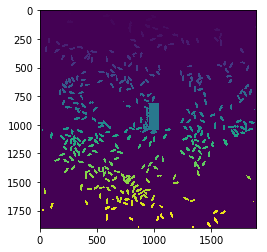

In [3]:
data_path = '/home/michaelneuder/github/bee_tracker/data/'
img_name = 'demo_frame.png'
img = cv2.imread(os.path.join(data_path, img_name))
img = np.asarray(img, dtype=float)[:,:,0]*(1/255)
img = abs(1-img)
img = img > skfilt.threshold_otsu(img)
img = skmorph.opening(img, skmorph.square(8))
img = skseg.clear_border(skmorph.remove_small_objects(img))
img = skmeas.label(img)
plt.imshow(img)

In [23]:
regions_ = skmeas.regionprops(img, cache=False)
regions_.sort(key= lambda x : x.area)

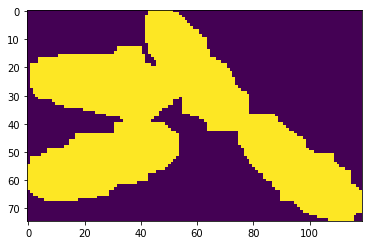

In [24]:
plt.imshow(regions_[-3].image)

In [25]:
regions_[-3].area / 1000

3.792

In [117]:
def erode_n_clusters(clusters):
    eroded_clusters = []
    for cluster in clusters:
        number_bees = round(cluster.area/1000)
        image = cluster.image.astype(float)
        cluster_bbox = cluster.bbox
        cont = True
        count = 0
        while cont:
            boundary, dims = findBoundary(image)
            boundary_map = createBoundaryMap(boundary, dims).astype('float')
            image -= boundary_map
            labeled_image = skmeas.label(image)
            if max(labeled_image.flatten()) != 1:
                region_props = skmeas.regionprops(labeled_image)
                region_props.sort(key= lambda x : x.area)
                # all but smallest
                for region in region_props[:-1]:
                    eroded_clusters.append((region, cluster_bbox))
                    image[region.bbox[0]:region.bbox[2], region.bbox[1]:region.bbox[3]] = np.zeros((region.bbox[2]-region.bbox[0], region.bbox[3]-region.bbox[1]))
                    count += 1
                    if count == number_bees-1:
                        cont = False
                        eroded_clusters.append((region_props[-1], cluster_bbox))
                        break
    return eroded_clusters

In [118]:
demo = erode_n_clusters([regions_[-3]])

In [119]:
demo

[(<skimage.measure._regionprops._RegionProperties at 0x7925ddc42e80>,
  (960, 505, 1035, 624)),
 (<skimage.measure._regionprops._RegionProperties at 0x7925dd5c2b70>,
  (960, 505, 1035, 624)),
 (<skimage.measure._regionprops._RegionProperties at 0x7925ddc42d68>,
  (960, 505, 1035, 624)),
 (<skimage.measure._regionprops._RegionProperties at 0x7925dd5c2898>,
  (960, 505, 1035, 624))]

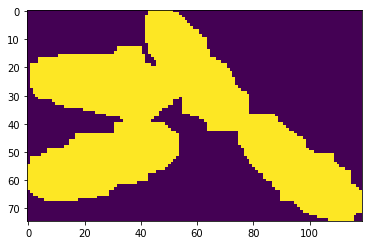

In [122]:
plt.imshow(regions_[-3].image)

In [138]:
img = regions_[-3].image.astype('float')
for region in demo:
    print(round(region[0].centroid[0]),round(region[0].centroid[1]))
    img[int(round(region[0].centroid[0])),int(round(region[0].centroid[1]))] = 1/2

53.0 27.0
56.0 96.0
23.0 59.0
27.0 33.0


In [139]:
img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

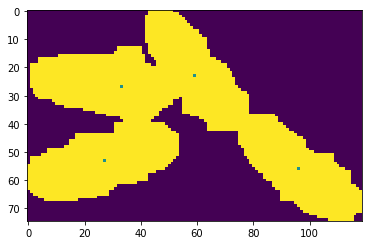

In [140]:
plt.imshow(img)

In [22]:
def findBoundary(image):
    boundary = []
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            if image[row][col] == 1:
                try:
                    if image[row][col+1] == 0 or image[row][col-1] == 0 \
                    or image[row+1][col] == 0 or image[row-1][col] == 0:
                        boundary.append((row, col))
                except IndexError:
                    boundary.append((row,col))
    return boundary, image.shape

def createBoundaryMap(boundary, dims):
    boundary_view = np.zeros(dims)
    for boundary_val in boundary:
        boundary_view[boundary_val[0]][boundary_val[1]] = 1
    return boundary_view